In [0]:
#Importing first essential libraries

import cv2
import numpy as np
from tqdm import tqdm
from random import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [8]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [9]:
#load our test and train data

batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of '/content/drive/My Drive/DatasetModak/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/DatasetModak/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for test data
test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/DatasetModak/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 664 images belonging to 2 classes.
Found 161 images belonging to 2 classes.


# Model Building

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

hist = model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# Fit Data

In [0]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

In [14]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=test_generator,
        validation_steps=800 // batch_size,
        callbacks=[checkpoint])
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
31/31 [==============================] - 112s 4s/step - loss: 0.6719 - acc: 0.5805 - val_loss: 0.6370 - val_acc: 0.6522

Epoch 00001: val_acc improved from -inf to 0.65217, saving model to model-001-0.580357-0.652174.h5
Epoch 2/50
31/31 [==============================] - 26s 833ms/step - loss: 0.6356 - acc: 0.6633 - val_loss: 0.6257 - val_acc: 0.6646

Epoch 00002: val_acc improved from 0.65217 to 0.66460, saving model to model-002-0.656798-0.664596.h5
Epoch 3/50
31/31 [==============================] - 25s 805ms/step - loss: 0.5903 - acc: 0.6891 - val_loss: 0.6319 - val_acc: 0.6522

Epoch 00003: val_acc did not improve from 0.66460
Epoch 4/50
31/31 [==============================] - 25s 791ms/step - loss: 0.5358 - acc: 0.7058 - val_loss: 0.6249 - val_acc: 0.6832

Epoch 00004: val_acc improved from 0.66460 to 0.68323, saving model to model-004-0.703863-0.683230.h5
Epoch 5/50
31/31 [==============================] - 24s 780ms/step - loss: 0.4928 - acc: 0.7490 - val_loss: 0.644

# Evaluation

In [0]:
true_classes = test_generator.classes
print(len(true_classes))


predictions = model.predict(test_generator)
#predicted_classes = np.argmax(predictions, axis=1)
# print(predictions)
type(predictions)
type(true_classes)
true_classes.tolist()

In [18]:
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

# print(predictions)
predictions.shape

(161, 1)

In [19]:
predictions = predictions.tolist()

len(predictions)



161

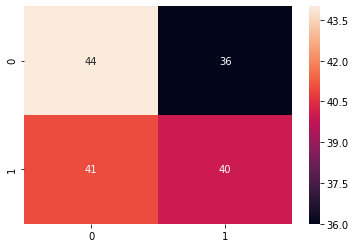

In [20]:
# Confusion Matrix

cm = confusion_matrix(true_classes, predictions)

sns.heatmap(cm, annot=True)

